# Pneumonia Detector Using VGG16

**About the Lung MRI Images dataset:**<br>
The dataset contains 3 folders of chest x-rays: test, train, and val. Each folder contains a set of Pneumonia images as well as Normal images. You may find the images from https://github.com/USKhan101/ML_Pneumonia_detection.git 

## Import Necessary Modules

In [130]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import numpy as np
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, roc_auc_score, auc, recall_score, precision_score
import matplotlib.pyplot as plt
import time
import h5py
import glob
from keras.models import load_model
from os import listdir

%matplotlib inline

### Load up the data:

1. Read the image for normalizied 256x256 pixels from .h5 file.
2. Append the image to <i>X</i> and its label to <i>y</i>.<br>

Load up the data from the image data filepath.<br>

In [87]:
IMG_WIDTH, IMG_HEIGHT = (256, 256)
model_name = 'vgg16'
data_label = 'normalized' # Referenced in the file creation part towards the middle of the code.
file_path = 'Pneumonia_Image_Data/normalized_rawdata.h5'

# Open the .h5 file for reading
with h5py.File(file_path, 'r') as file:
    # Read training data and labels
    X_train = file['train_data'][:]
    y_train = file['train_label'][:]

    # Read validation data and labels
    X_val = file['val_data'][:]
    y_val = file['val_label'][:]

    # Read test data and labels
    X_test = file['test_data'][:]
    y_test = file['test_label'][:]

print(f'Number of examples in train is: {len(X_train)}')
print(f'X shape is: {X_train.shape}')
print(f'y shape is: {y_train.shape}')

print(f'Number of examples in val is: {len(X_val)}')
print(f'X shape is: {X_val.shape}')
print(f'y shape is: {y_val.shape}')

print(f'Number of examples in test is: {len(X_test)}')
print(f'X shape is: {X_test.shape}')
print(f'y shape is: {y_test.shape}')


Number of examples in train is: 4099
X shape is: (4099, 256, 256)
y shape is: (4099,)
Number of examples in val is: 585
X shape is: (585, 256, 256)
y shape is: (585,)
Number of examples in test is: 1172
X shape is: (1172, 256, 256)
y shape is: (1172,)


### Plot sample images:

In [88]:
def plot_sample_images(X, y, n=10):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 5
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Pneumonia: {label_to_str(label)}")
        plt.show()

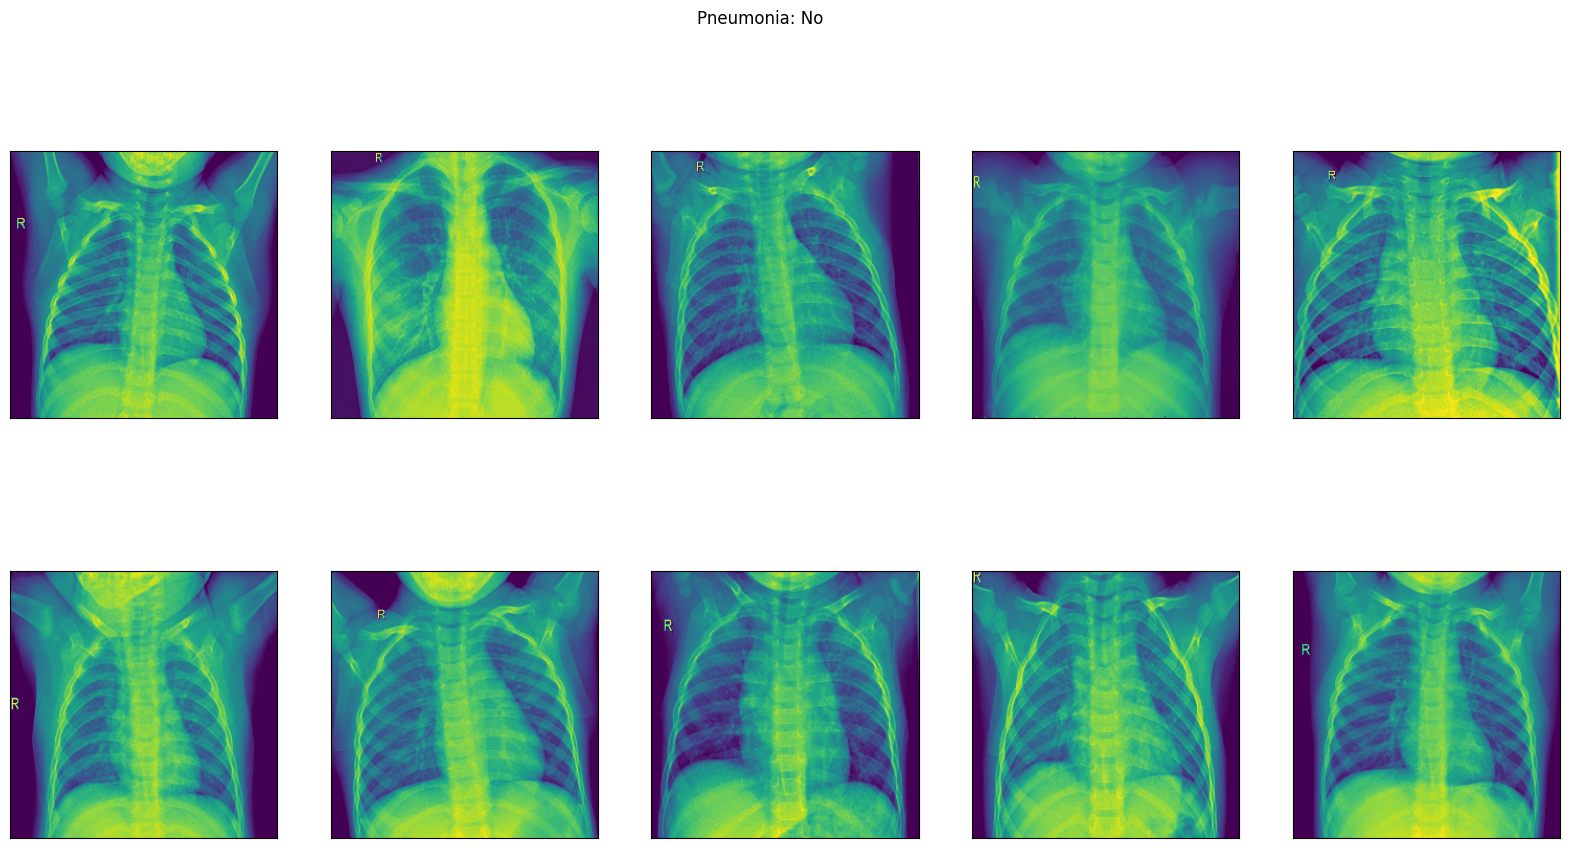

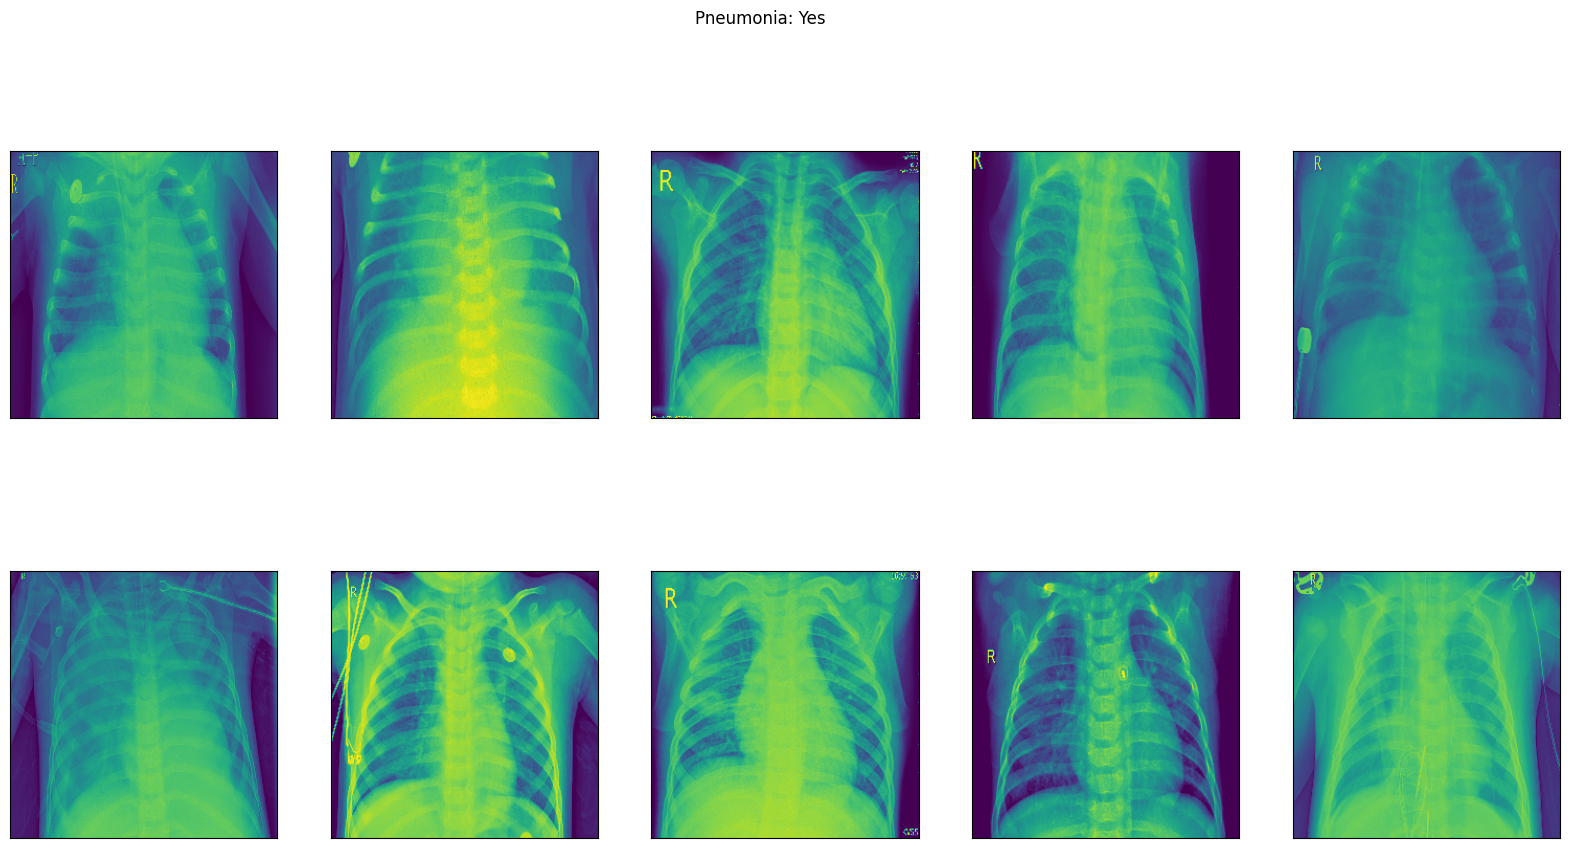

In [89]:
plot_sample_images(X_train, y_train)

In [90]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 4099
number of development examples = 585
number of test examples = 1172
X_train shape: (4099, 256, 256)
Y_train shape: (4099,)
X_val (dev) shape: (585, 256, 256)
Y_val (dev) shape: (585,)
X_test shape: (1172, 256, 256)
Y_test shape: (1172,)


Some helper functions:

In [91]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [92]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the MLP model

In [93]:
def model(input_shape):
    """
    Build a simple Multi-Layer Perceptron (MLP) model.

    Arguments:
        input_shape: A tuple representing the shape of the input features.

    Returns:
        model: A Model object representing the MLP model.
    """
    # Define the input layer
    X_input = Input(shape=input_shape)

    # Flatten the input (if it's not already flattened)
    X = Flatten()(X_input)

    # Add fully connected layers
    X = Dense(128, activation='relu')(X)
    X = Dense(64, activation='relu')(X)
    X = Dense(32, activation='relu')(X)

    # Output layer with sigmoid activation for binary classification
    predictions = Dense(1, activation='sigmoid')(X)

    # Create the model
    model = Model(inputs=X_input, outputs=predictions, name= model_name + '_model')

    return model

Define the image shape:

In [94]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 1)

In [95]:
model = model(IMG_SHAPE)

In [96]:
model.summary()

Model: "mlp_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,399,105 (32.04 MB)

 Trainable params: 8,399,105 (32.04 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model:

In [97]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [98]:
# tensorboard
log_file_name = f'pneumonia_detector_'+model_name+'_'+data_label+'_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [100]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath = 'models/'+model_name+'-'+data_label+'-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras'
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

## Train the model

In [101]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7491 - loss: 1.1133
Epoch 1: val_accuracy improved from -inf to 0.92479, saving model to models/mlp-normalized-parameters-improvement-01-0.92.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 180ms/step - accuracy: 0.7497 - loss: 1.1090 - val_accuracy: 0.9248 - val_loss: 0.2110
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9103 - loss: 0.2313
Epoch 2: val_accuracy did not improve from 0.92479
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.9103 - loss: 0.2313 - val_accuracy: 0.9248 - val_loss: 0.2004
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9254 - loss: 0.1816
Epoch 3: val_accuracy did not improve from 0.92479
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - accuracy: 0.9254 - loss: 0.1816 - val_accuracy: 0.8701 - val_loss: 0.3687
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9275 - loss: 0.1822
Epoch 4: val_accuracy did not improve from 0.92479
129/129

Let's train for a few more epochs:

In [102]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
 30/129 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.9404 - loss: 0.1631

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9359 - loss: 0.1729
Epoch 1: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.9359 - loss: 0.1728 - val_accuracy: 0.9145 - val_loss: 0.2201
Epoch 2/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9472 - loss: 0.1443
Epoch 2: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.9472 - loss: 0.1443 - val_accuracy: 0.9299 - val_loss: 0.1922
Epoch 3/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9524 - loss: 0.1247
Epoch 3: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.9523 - loss: 0.1250 - val_accuracy: 0.8547 - val_loss: 0.4100
Elapsed time: 0:1:3.4


In [103]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9386 - loss: 0.1545
Epoch 1: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.9387 - loss: 0.1544 - val_accuracy: 0.9248 - val_loss: 0.1963
Epoch 2/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9407 - loss: 0.1555
Epoch 2: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 0.9407 - loss: 0.1555 - val_accuracy: 0.9265 - val_loss: 0.2190
Epoch 3/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9421 - loss: 0.1616
Epoch 3: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.9420 - loss: 0.1615 - val_accuracy: 0.9145 - val_loss: 0.2190
Elapsed time: 0:0:58.8


In [104]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
 24/129 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - accuracy: 0.9320 - loss: 0.1495

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9396 - loss: 0.1539
Epoch 1: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.9397 - loss: 0.1538 - val_accuracy: 0.9248 - val_loss: 0.2117
Epoch 2/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9434 - loss: 0.1554
Epoch 2: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - accuracy: 0.9434 - loss: 0.1553 - val_accuracy: 0.8359 - val_loss: 0.4579
Epoch 3/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8832 - loss: 0.2923
Epoch 3: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.8835 - loss: 0.2916 - val_accuracy: 0.9248 - val_loss: 0.2017
Elapsed time: 0:1:23.5


In [105]:
start_time = time.time()

mlpmodel.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9388 - loss: 0.1611
Epoch 1: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - accuracy: 0.9388 - loss: 0.1612 - val_accuracy: 0.9299 - val_loss: 0.1739
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9283 - loss: 0.1761
Epoch 2: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.9284 - loss: 0.1760 - val_accuracy: 0.9179 - val_loss: 0.2079
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9496 - loss: 0.1339
Epoch 3: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.9495 - loss: 0.1341 - val_accuracy: 0.9248 - val_loss: 0.1795
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9490 - loss: 0.1369
Epoch 4: val_accuracy did not improve from 0.92991
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - accuracy: 0.9490 - loss: 0.1370 - val_accu

In [106]:
history = model.history.history

In [107]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [108]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

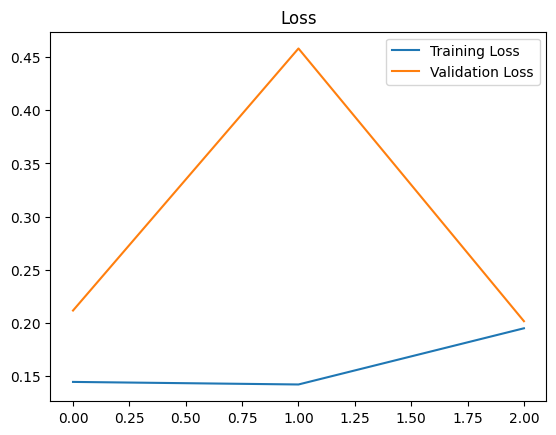

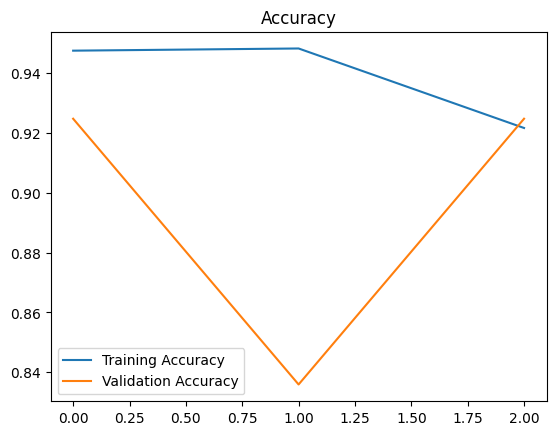

In [109]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy) and test the data:

### Load the best model

In [110]:

# Find the filepath of the best model using glob
best_model_filepath = glob.glob('models/'+model_name+'-'+data_label+'-parameters-improvement-*.keras')
# Sort the list of filepaths to ensure the latest (best) model comes first
best_model_filepath.sort(reverse=True)
# Load the best model
best_model = load_model(filepath=best_model_filepath[0])
print(best_model_filepath[0])

models\mlp-normalized-parameters-improvement-10-0.93.keras


Evaluate the best model on the testing data:

In [111]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8906 - loss: 0.2738

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8977 - loss: 0.2562


### Accuracy and Loss

In [112]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.1725936383008957
Test Accuracy = 0.9308874011039734


### Recall, Precision, and F1 Score

In [113]:
y_test_prob = best_model.predict(X_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [114]:
y_test_pred = (y_test_prob >= 0.5).astype(int)
# Compute recall
recall = recall_score(y_test, y_test_pred)

# Compute precision
precision = precision_score(y_test, y_test_pred)

print(f"Recall: {recall}")
print(f"Precision: {precision}")

# F1 Score
f1score = compute_f1_score(y_test, y_test_pred)
print(f"F1 score: {f1score}")

Recall: 0.9590643274853801
Precision: 0.9468822170900693
F1 score: 0.9529343404997095


### Mean Square Error

In [115]:
mse = mean_squared_error(y_test, y_test_prob)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.05144297331571579


### Confusion Matrix

In [116]:
y_test_pred = (y_test_prob >= 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[271  46]
 [ 35 820]]


### ROC curve and AUC

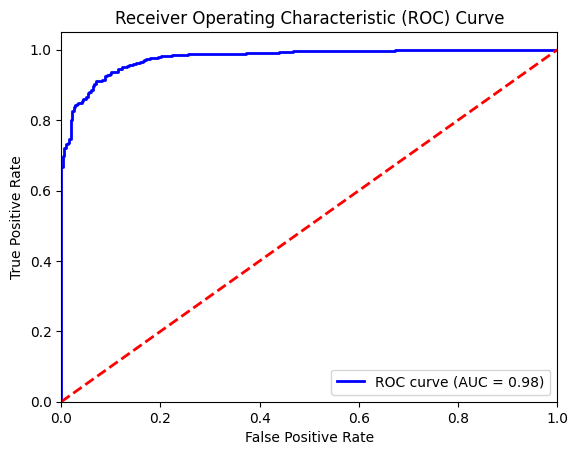

AUC: <function auc at 0x00000196AB75F9C0>


In [131]:
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)  # Renamed variable to avoid conflict

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {auc}")

Let's also find the f1 score on the validation data:

In [132]:
y_val_prob = best_model.predict(X_val)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [133]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.952819332566168


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [134]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [135]:
# the whole data
data_percentage(y_train)

Number of examples: 4099
Percentage of positive examples: 72.969016833374%, number of pos examples: 2991
Percentage of negative examples: 27.030983166626008%, number of neg examples: 1108


In [136]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 4099
Percentage of positive examples: 72.969016833374%, number of pos examples: 2991
Percentage of negative examples: 27.030983166626008%, number of neg examples: 1108
Validation Data:
Number of examples: 585
Percentage of positive examples: 72.99145299145299%, number of pos examples: 427
Percentage of negative examples: 27.00854700854701%, number of neg examples: 158
Testing Data:
Number of examples: 1172
Percentage of positive examples: 72.95221843003414%, number of pos examples: 855
Percentage of negative examples: 27.04778156996587%, number of neg examples: 317


# Conclusion:

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  |             |       |
| F1 score  |            |      |